In [1]:
#!pip install darts

1. Análisis Exploratorio:
- Describir la serie de tiempo y visualizarla.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, Theta, RNNModel
from darts.metrics import mae, rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

C:\Users\Jose\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


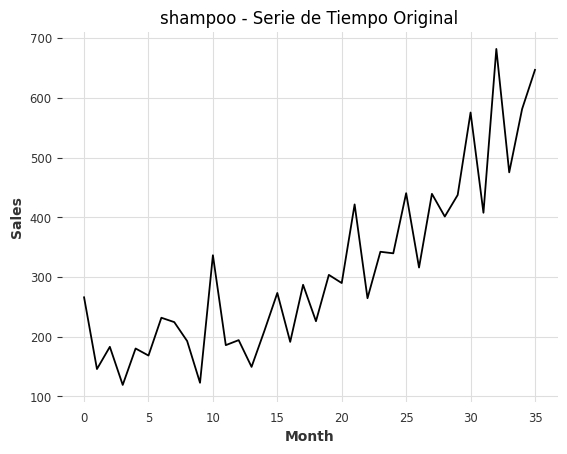

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el DataFrame desde el archivo CSV
dataset = pd.read_csv('./shampoo.csv')

# Definir la configuración con las columnas adecuadas
config = {
    'time': 'Month', 
    'value': 'Sales' 
}

year = 1900  # inicio de datos
new_date = []
for date in dataset[config['time']]:
    parts = date.split('-')
    new_date.append(f"{year + int(parts[0]) - 1}-{int(parts[1]):02d}")
dataset[config['time']] = new_date

# Acceder a la columna de valores
value_column = dataset[config['value']]

# Graficar la serie de tiempo
plt.plot(value_column)
plt.title("shampoo - Serie de Tiempo Original")
plt.xlabel(config['time'])  # Agrega una etiqueta al eje x con el nombre de la columna de tiempo
plt.ylabel(config['value'])  # Agrega una etiqueta al eje y con el nombre de la columna de valores
plt.show()



2. Promedios:
- Aplicar métodos de promedios y comparar los resultados con el conjunto original.

In [7]:
def promedio_movil(series, window_size):
    return series.rolling(window=window_size).mean()

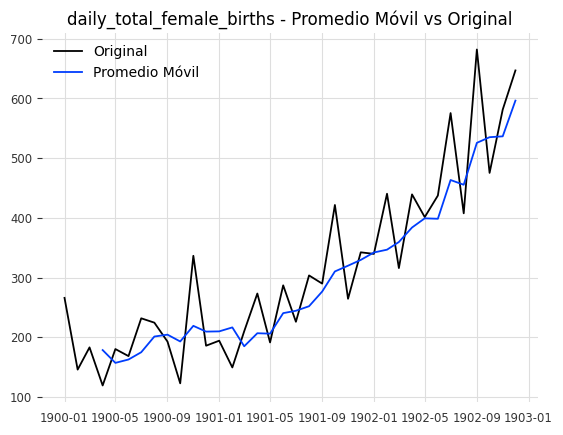

In [8]:
config = {
    'time': 'Month',    
    'value': 'Sales'  
}

# Crear la serie temporal 'series'
series = TimeSeries.from_dataframe(dataset, config['time'], config['value'])

# Calcular el promedio móvil
ma_series = promedio_movil(series.pd_dataframe()[config['value']], window_size=4)

# Graficar la serie original y el promedio móvil
plt.plot(series.pd_dataframe()[config['value']], label='Original')
plt.plot(ma_series, label='Promedio Móvil')
plt.legend()
plt.title("daily_total_female_births - Promedio Móvil vs Original")
plt.show()

3. SARIMA:
- Identificar parámetros y ajustar un modelo SARIMA

In [9]:
train, val = series.split_after(0.8)
# orden estacional
if len(train) >= 50: 
    seasonal_order = (1, 1, 1, 12)
else:
    seasonal_order = (0, 0, 0, 0)

sarima = SARIMAX(train.pd_dataframe(), order=(1, 1, 1), seasonal_order=seasonal_order)
sarima_fitted = sarima.fit()
sarima_forecast = sarima_fitted.get_forecast(steps=len(val)).predicted_mean
sarima_forecast_series = TimeSeries.from_series(pd.Series(sarima_forecast, index=val.pd_dataframe().index))
print(f"SARIMA - RMSE: {rmse(val, sarima_forecast_series)}")
print(f"SARIMA - MAE: {mae(val, sarima_forecast_series)}")

SARIMA - RMSE: 172.14429495127436
SARIMA - MAE: 141.73799940074164


4. Alisamiento Exponencial:
- Aplicar diferentes métodos de alisamiento exponencial y comparar.

In [10]:
exp_model = ExponentialSmoothing()
exp_model.fit(train)
exp_forecast = exp_model.predict(len(val))
print(f"Exponential Smoothing - RMSE: {rmse(val, exp_forecast)}")
print(f"Exponential Smoothing - MAE: {mae(val, exp_forecast)}")

Exponential Smoothing - RMSE: 101.06950903608562
Exponential Smoothing - MAE: 83.22733005035658


5. Prophet:
- Utilizar Prophet para modelar la serie de tiempo.

In [11]:
prophet_model = Prophet()
prophet_model.fit(train)
prophet_forecast = prophet_model.predict(len(val))
print(f"Prophet - RMSE: {rmse(val, prophet_forecast)}")
print(f"Prophet - MAE: {mae(val, prophet_forecast)}")

10:02:15 - cmdstanpy - INFO - Chain [1] start processing
10:02:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 229.83516680003095
Prophet - MAE: 191.6461129453044


6. Redes Neuronales:
- Implementar una red neuronal simple para prever la serie de tiempo

In [12]:
rnn_model = RNNModel(model='LSTM', input_chunk_length=12, output_chunk_length=1, n_epochs=200)
rnn_model.fit(train)
rnn_forecast = rnn_model.predict(len(val))
print(f"RNN - RMSE: {rmse(val, rnn_forecast)}")
print(f"RNN - MAE: {mae(val, rnn_forecast)}")

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s, train_loss=6.84e+4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, train_loss=6.84e+4]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s]
RNN - RMSE: 547.104065518059
RNN - MAE: 538.3011009542325


7. Comparación y Evaluación:
- Usar métricas como RMSE, MAE para comparar los modelos.

In [13]:
metrics = {}
metrics['SARIMA'] = [rmse(val, sarima_forecast_series), mae(val, sarima_forecast_series)]
metrics['Exponential'] = [rmse(val, exp_forecast), mae(val, exp_forecast)]
metrics['Prophet'] = [rmse(val, prophet_forecast), mae(val, prophet_forecast)]
metrics['RNN'] = [rmse(val, rnn_forecast), mae(val, rnn_forecast)]

In [14]:
best_rmse_model = min(metrics, key=lambda k: metrics[k][0])
best_mae_model = min(metrics, key=lambda k: metrics[k][1])

print(f"El mejor modelo por RMSE es: {best_rmse_model} con un valor de {metrics[best_rmse_model][0]}")
print(f"El mejor modelo por MAE es: {best_mae_model} con un valor de {metrics[best_mae_model][1]}")

El mejor modelo por RMSE es: Exponential con un valor de 101.06950903608562
El mejor modelo por MAE es: Exponential con un valor de 83.22733005035658
